In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
from scipy import optimize

# Stochastic Environment

In [2]:
n_advertisers = 6
q = np.array([0.9, 0.7, 0.5, 0.6, 0.85, 0.65]) # ad quality
v = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]) # advertisers value per click
valuation = v[0]
B = 30
n_users = 200

other_bids = np.random.uniform(0, 10*B/n_users, size = (n_advertisers-1, n_users))

n_slots = 3
lmb = np.array([0.4, 0.7, 0.9])

K=11
available_bids = np.array([round(i, 1) for i in np.linspace(0,1,K)]) # Discretization of the set of bids

# Truthful Auctions
For truthful auctions with multiple slots we need to use the VCG auction to guarantee the bidders to bid truthful.

In [3]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [4]:
class VCGAuction(Auction):
    def __init__(self, ctrs, lambdas):
        self.ctrs = ctrs
        self.lambdas = lambdas
        self.n_adv = len(self.ctrs)
        self.n_slots = len(self.lambdas)

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.n_slots:]
        winners_values = adv_values[winners]
        return winners, winners_values

    def get_payments_per_click(self, winners, values, bids):
        payments_per_click = np.zeros(self.n_slots)
        for i,w in enumerate(winners):
            Y = sum(np.delete(values, i)*self.lambdas[-self.n_slots+1:])
            X = sum(np.delete(values*self.lambdas, i))
            payments_per_click[i] = (Y-X)/(self.lambdas[i]*self.ctrs[w])
        return payments_per_click.round(2)

In [5]:
# solve optimization problem for optimal bidding strategy
def get_clairvoyant_truthful(B, other_bids, n_users, ctrs, lambdas, values):
    my_valuation = values[0]
    auction = VCGAuction(ctrs, lambdas)
    ## I compute my sequence of utilities at every round
    payments = np.zeros(n_users)
    utilities = np.zeros(n_users)
    for t in range(n_users):
        winners, payments_per_click = auction.round(bids=np.append(my_valuation,other_bids[t]))
        if 0 in winners:
            my_slot = np.where(winners == 0)[0]
            payments[t] = payments_per_click[my_slot][0]
    
    utilities = my_valuation-payments

    # greediliy pick best bids
    sorted_round_payments = np.flip(np.argsort(utilities)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0
    i = 0
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_payments[i]] = 1
        clairvoyant_payments[sorted_round_payments[i]] = payments[sorted_round_payments[i]]
        clairvoyant_utilities[sorted_round_payments[i]] = my_valuation - payments[sorted_round_payments[i]]
        c += payments[sorted_round_payments[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments


In [6]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 0
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)

    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

In [7]:
def run_truthful_auctions(n_users, v, B, q, lmb, other_bids):
    eta = 1/np.sqrt(n_users) # from theory
    agent = MultiplicativePacingAgent(valuation=v[0],
                                    budget=B,
                                    T=n_users,
                                    eta=eta)

    auction = VCGAuction(q,lmb)

    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    total_wins = 0

    np.random.seed(18)
    for u in range(n_users):
        my_bid = agent.bid()
        all_bids = np.append(my_bid, np.transpose(other_bids)[u].ravel())
        winners, payments_per_click = auction.round(bids=all_bids)
        if 0 in winners:
            my_slot = np.where(winners == 0)[0]
            c_t = payments_per_click[my_slot][0]
            f_t = v[0]-c_t
            total_wins+=1
        else:
            c_t,f_t = 0,0
        agent.update(f_t, c_t)
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
    print(f'Total # of Wins: {total_wins}')

    return my_bids, my_payments, utilities

In [8]:
def draw_plots(my_bids, my_payments, utilities, clairvoyant_utilities, B, title):
    # Calculate cumulative values
    cumulative_payments = np.cumsum(my_payments)
    cumulative_regret = np.cumsum(clairvoyant_utilities - utilities)

    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # First subplot: Cumulative Payments
    axs[0].plot(cumulative_payments)
    axs[0].set_xlabel('$t$')
    axs[0].set_ylabel('$\sum c_t$')
    axs[0].axhline(B, color='red', label='Budget')
    axs[0].legend()
    axs[0].set_title('Cumulative Payments of Multiplicative Pacing')

    # Second subplot: Cumulative Regret
    axs[1].plot(cumulative_regret)
    axs[1].set_xlabel('$t$')
    axs[1].set_ylabel('$\sum f_t$')
    axs[1].set_title('Cumulative Regret of Multiplicative Pacing')

    # Third subplot: Chosen Bids
    axs[2].plot(my_bids)
    axs[2].set_xlabel('$t$')
    axs[2].set_ylabel('$b_t$')
    axs[2].set_title('Chosen Bids')

    # Adjust layout
    plt.tight_layout()

    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)

    # Show plot
    plt.show()

In [9]:
def evaluate_param_truthful(n_users, v, B, q, lmb):
    other_bids = np.random.uniform(0, 10*B/n_users, size = (n_advertisers-1, n_users))
    my_bids, my_payments, utilities = run_truthful_auctions(n_users, v, B, q, lmb, other_bids)
    clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, np.transpose(other_bids), n_users, q, lmb, v)
    variables_str = f"n_users={n_users}, B={B}"
    draw_plots(my_bids, my_payments, utilities, clairvoyant_utilities, B, f"Truthful auction plots with parameters: {variables_str}")

Total # of Wins: 134


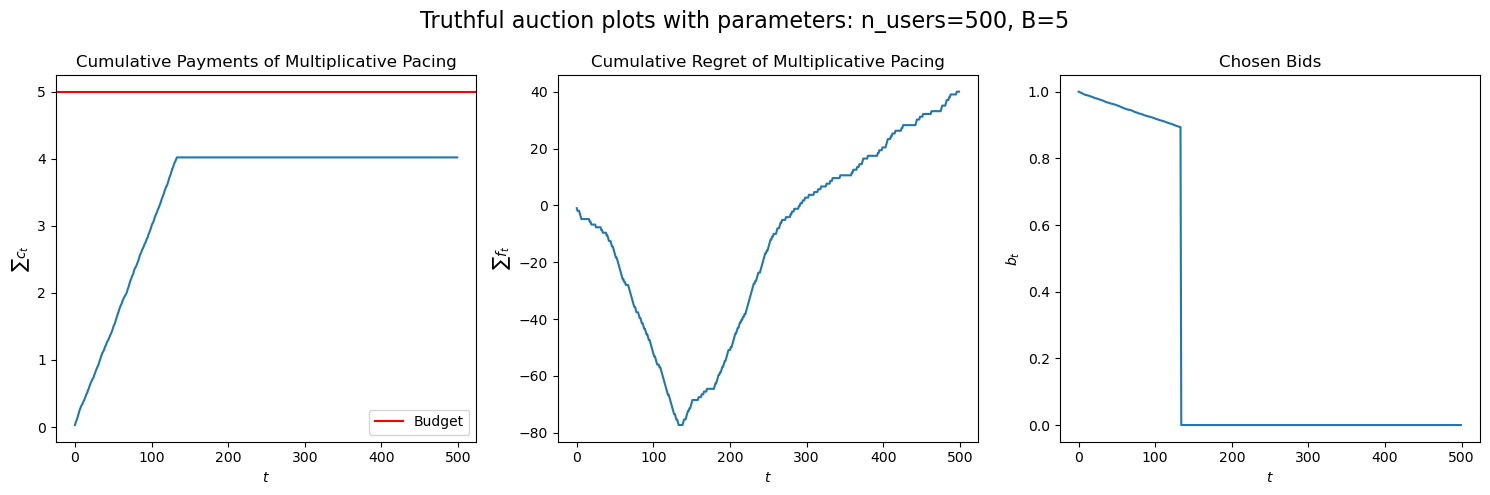

In [10]:
n_users = 500
B = 5
evaluate_param_truthful(n_users, v, B, q, lmb)

Total # of Wins: 280


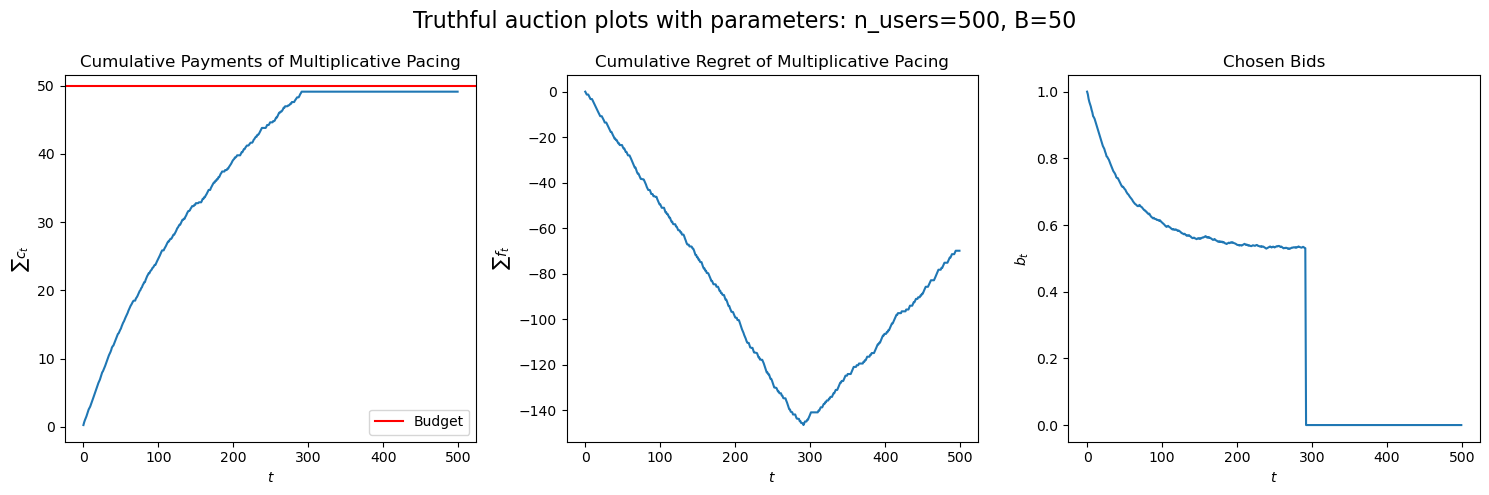

In [11]:
B = 50
evaluate_param_truthful(n_users, v, B, q, lmb)

Total # of Wins: 423


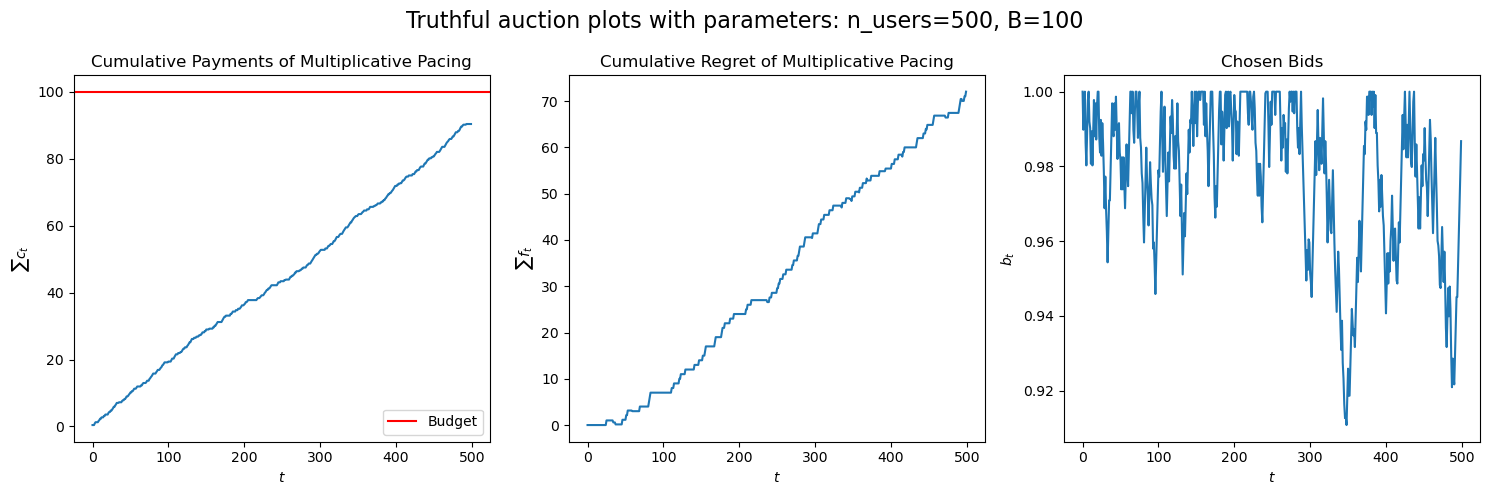

In [12]:
B = 100
n_users = 500
evaluate_param_truthful(n_users, v, B, q, lmb)

Total # of Wins: 290


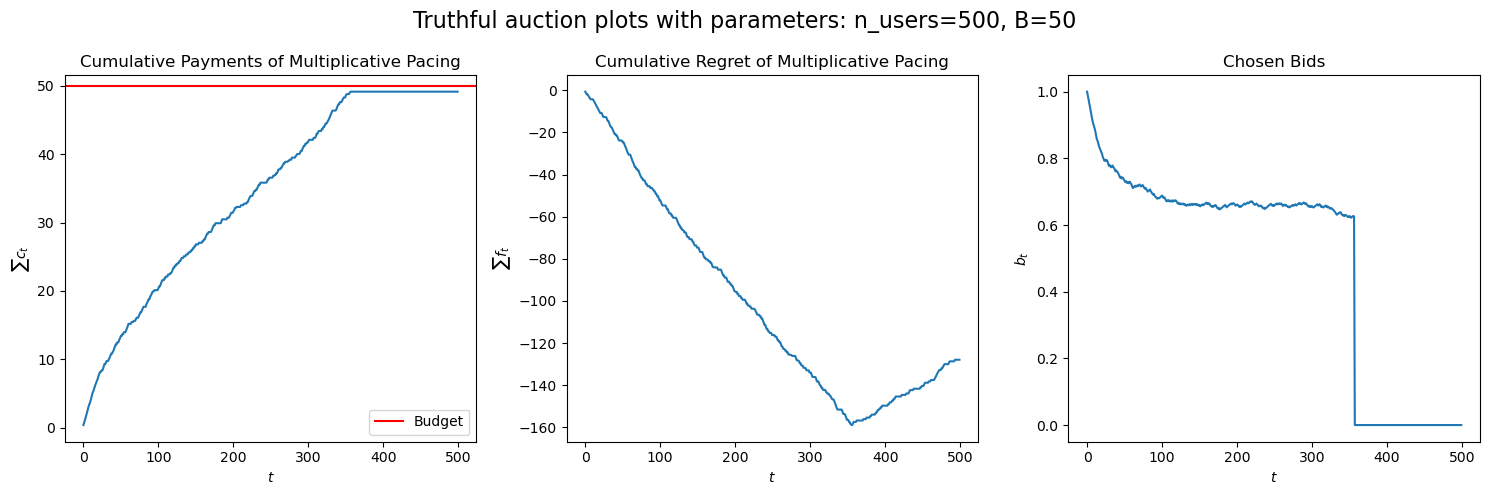

In [13]:
B = 50
q = np.array([1, 1, 1, 1, 1, 1]) # ad quality
evaluate_param_truthful(n_users, v, B, q, lmb)

When running our implementation of multiplicative pacing on truthful auctions we experiment with the ratio of number of users and budget, e.g. different budget per timestamp. All other parameters are fixed first. We can see that the first bid is always the value of the auction, which is 1 in our case. If we choose the budget too small for our time frame, we deplete our budget before being able to learn the right per-timeslot-bid. That explains why we are not able to keep our budget until the end. At first it is surprising that the cumulative regret is negative but that is because we choose the clairvoyant to choose his strategy greedily. Those, we perform better than the clairvoyant.

# UCB-like bidding algorithm for generalised second price auction

In [14]:
class GeneralSecondPriceAuction(Auction):
    def __init__(self, ctrs, lambdas):
        self.ctrs = ctrs
        self.lambdas = lambdas
        self.n_adv = len(self.ctrs)
        self.n_slots = len(self.lambdas)

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.n_slots:]
        winners_values = adv_values[winners]
        return winners, winners_values

    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(self.ctrs*bids)
        shifted_bids = np.zeros(len(bids))
        for i in range(1,len(adv_ranking)):
          shifted_bids[adv_ranking[i]] = bids[adv_ranking[i-1]]
        payments_per_click = np.zeros(self.n_slots)
        for i,w in enumerate(winners):
          payments_per_click[i] = shifted_bids[w]
        return payments_per_click.round(2)

In [15]:
# solve optimization problem for optimal bidding strategy in generalised second price auction
def get_clairvoyant_gsp(B, other_bids, n_users, ctrs, lambdas, values):
    auction = GeneralSecondPriceAuction(ctrs, lambdas)
    available_bids = np.linspace(0, 1, 11)
    win_probabilities = stats.beta.cdf(available_bids, n_advertisers, 1)
    ## I find the best expected policy
    c = -(valuation - available_bids)*win_probabilities
    A_ub = [available_bids*win_probabilities]
    b_ub = [B/n_users]
    A_eq = [np.ones(len(available_bids))]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    gamma = res.x
    expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
    expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]
    payments = np.zeros(n_users)
    for t in range(n_users):
        winners, payments_per_click = auction.round(bids=np.append(expected_clairvoyant_bids[t],other_bids[t]))
        if 0 in winners:
            my_slot = np.where(winners == 0)[0]
            payments[t] = payments_per_click[my_slot][0]
    # Apply expected optimal policy even when reaching budget depletion, because we respect the budget in expectation
    clairvoyant_bids = expected_clairvoyant_bids
    clairvoyant_payments = payments
    clairvoyant_utilities = expected_clairvoyant_bids - payments
    #clairvoyant_utilities = expected_clairvoyant_utilities
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

In [16]:
class UCBBiddingAgent:
    def __init__(self, bids_set, budget, valuation, T):
      self.bids_set = bids_set
      self.budget = budget
      self.valuation = valuation
      self.T = T
      self.rho = self.budget/self.T
      self.t = 0
      self.bids_history = []
      self.f = []
      self.c = []

    def bid(self):
        if self.budget < 1:
          self.bids_history.append(0)
          return 0
        elif self.t<len(self.bids_set):
          self.bids_history.append(self.bids_set[self.t])
          return self.bids_set[self.t]
        else:
          f_opti, c_opti, sup, best_bid = 0, 0, 0, 0
          for bid in self.bids_set:
            f_t = 0
            c_t = 0
            N = 0
            for i in range(self.t):
              if (self.bids_history[i] == bid):
                f_t += self.f[i]
                c_t += self.c[i]
                N += 1
            f_t = f_t/N
            c_t = c_t/N
            f_ucb = f_t + np.sqrt(2*math.log(self.T)/N)
            c_lcb = c_t - np.sqrt(2*math.log(self.T)/N)
            if (c_lcb<=self.rho and f_ucb>sup):
              sup = f_ucb
              f_opti = f_t
              c_opti = c_t
              best_bid = bid
          self.bids_history.append(best_bid)
          return best_bid

    def update(self, f_t, c_t):
      self.f.append(f_t)
      self.c.append(c_t)
      self.budget -= c_t
      self.t += 1

In [17]:
def run_nontruthful_auctions(n_users, v, B, q, lmb, other_bids):
    agent = UCBBiddingAgent(bids_set=available_bids,
                                    budget=B,
                                    valuation=valuation,
                                    T=n_users)

    auction = GeneralSecondPriceAuction(q, lmb)

    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    total_wins = 0

    np.random.seed(18)
    for u in range(n_users):
        my_bid = agent.bid()
        all_bids = np.append(my_bid, np.transpose(other_bids)[u].ravel())
        winners, payments_per_click = auction.round(bids=all_bids)
        if 0 in winners:
            my_slot = np.where(winners == 0)[0]
            c_t = payments_per_click[my_slot]
            f_t = v[0]-c_t
            total_wins+=1
        else:
            c_t,f_t = 0,0
        agent.update(f_t, c_t)
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
    print(f'Total # of Wins: {total_wins}/{n_users}')
    return my_bids, my_payments, utilities

In [18]:
def evaluate_param_nontruthful(n_users, v, B, q, lmb):
    other_bids = np.random.uniform(0, 10*B/n_users, size = (n_advertisers-1, n_users))
    my_bids, my_payments, utilities = run_nontruthful_auctions(n_users, v, B, q, lmb, other_bids)
    clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_gsp(B, np.transpose(other_bids), n_users, q, lmb, v)
    variables_str = f"n_users={n_users}, B={B}"
    draw_plots(my_bids, my_payments, utilities, clairvoyant_utilities, B, f"Untruthful auction plots with parameters: {variables_str}")

Total # of Wins: 84/500


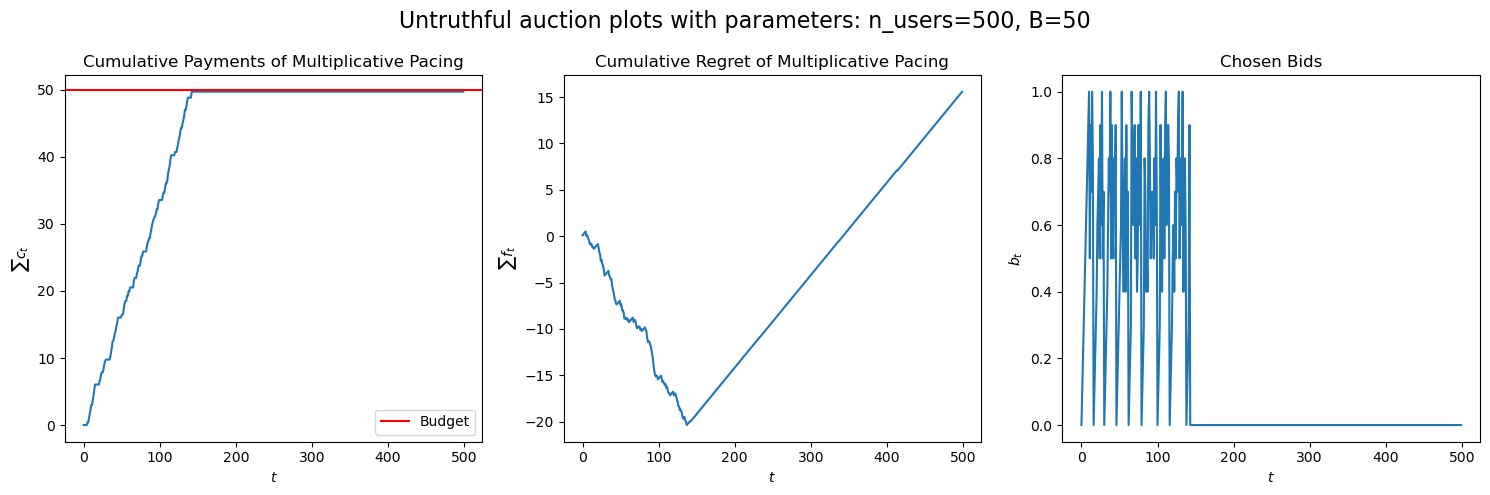

In [37]:
n_users = 500
B = 50
q = np.array([1, 1, 1, 1, 1, 1]) # ad quality
evaluate_param_nontruthful(n_users, v, B, q, lmb)

Total # of Wins: 18/200


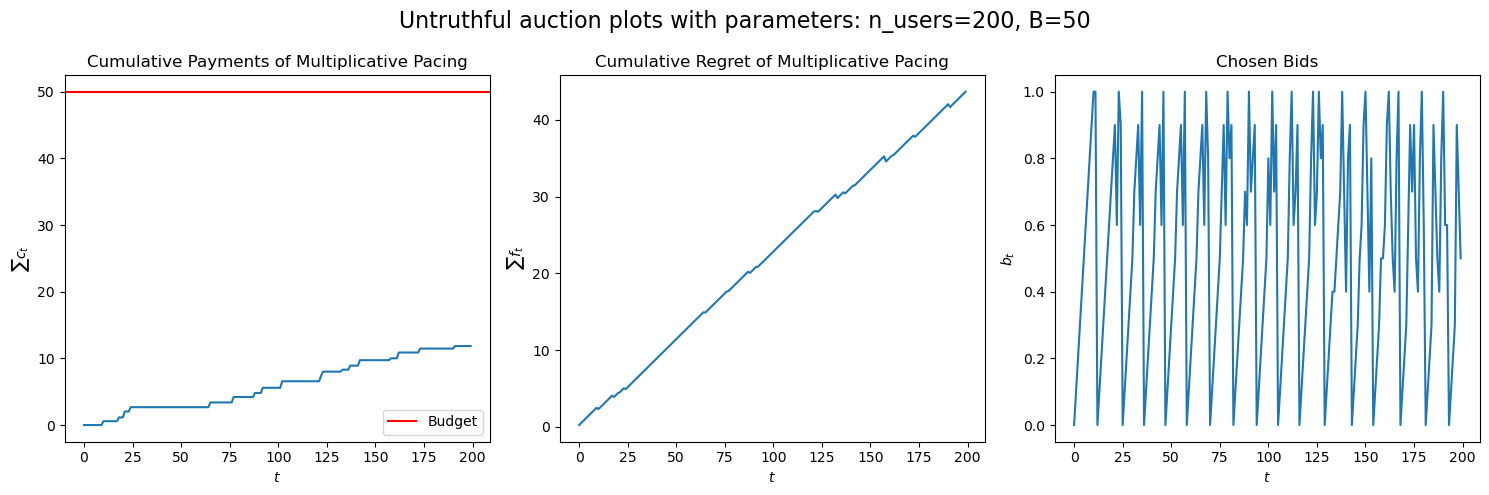

In [38]:
n_users = 200
B = 50
evaluate_param_nontruthful(n_users, v, B, q, lmb)

Looking at the results where we compare the algorithm with the same parameters just a different time horizon, we observe that the algorithm is not able to adapt to the changing of the time horizon. For smaller time horizon, we not deplete our budget at all. But for bigger time horizon, we deplete our budget too fast. But in total, the regret is $O(\sqrt{n})$

Total # of Wins: 131/500


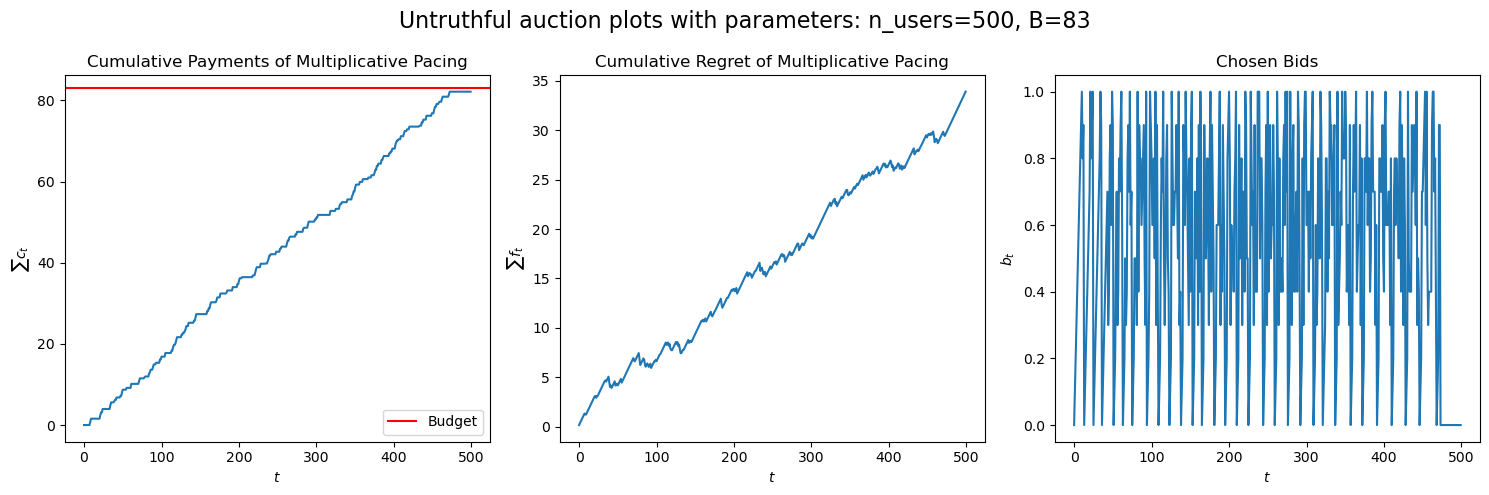

In [51]:
n_users = 500
B = 83
evaluate_param_nontruthful(n_users, v, B, q, lmb)

Choosing the number of users of 500 and budget of 83, the algorithm achieves the optimal balance between bidding too much and too less such that the budget is not depleted until the end.